## Lesson 12.4 - Seaborn: Visualizing linear relationships

*Facsimile of [Seaborn tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial.html).*

Many datasets contain multiple quantitative variables, and the goal of an analysis is often to relate those variables to each other. We :ref:`previously discussed <distribution_tutorial>` functions that can accomplish this by showing the joint distribution of two variables. It can be very helpful, though, to use statistical models to estimate a simple relationship between two noisy sets of observations. The functions discussed in this chapter will do so through the common framework of linear regression.

In the spirit of Tukey, the regression plots in seaborn are primarily intended to add a visual guide that helps to emphasize patterns in a dataset during exploratory data analyses. That is to say that seaborn is not itself a package for statistical analysis. To obtain quantitative measures related to the fit of regression models, you should use `statsmodels <http://statsmodels.sourceforge.net/>`_. The goal of seaborn, however, is to make exploring a dataset through visualization quick and easy, as doing so is just as (if not more) important than exploring a dataset through tables of statistics.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set(color_codes=True)

In [4]:
np.random.seed(sum(map(ord, "regression")))

In [5]:
tips = sns.load_dataset("tips")

Functions to draw linear regression models
------------------------------------------

Two main functions in seaborn are used to visualize a linear relationship as determined through regression. These functions, `regplot` and `lmplot` are closely related, and share much of their core functionality. It is important to understand the ways they differ, however, so that you can quickly choose the correct tool for particular job.

In the simplest invocation, both functions draw a scatterplot of two variables, ``x`` and ``y``, and then fit the regression model ``y ~ x`` and plot the resulting regression line and a 95% confidence interval for that regression:

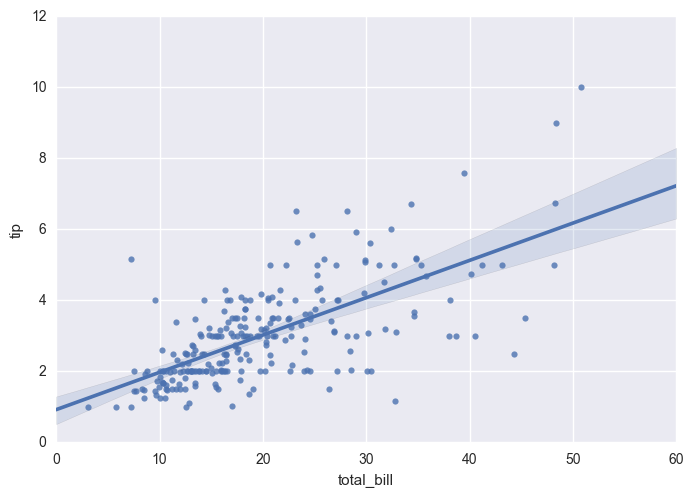

In [6]:
sns.regplot(x="total_bill", y="tip", data=tips)

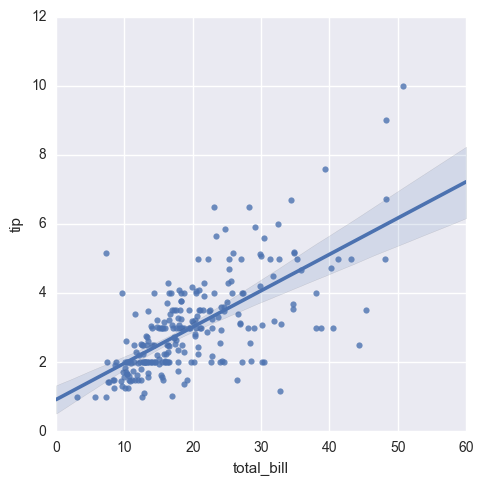

In [7]:
sns.lmplot(x="total_bill", y="tip", data=tips)

You should note that the resulting plots are identical, except that the figure shapes are different. We will explain why this is shortly. For now, the other main difference to know about is that `regplot` accepts the ``x`` and ``y`` variables in a variety of formats including simple numpy arrays, pandas ``Series`` objects, or as references to variables in a pandas ``DataFrame`` object passed to ``data``. In contrast, `lmplot` has ``data`` as a required parameter and the ``x`` and ``y`` variables must be specified as strings. This data format is called "long-form" or `"tidy" <http://vita.had.co.nz/papers/tidy-data.pdf>`_ data. Other than this input flexibility, `regplot` possesses a subset of `lmplot`'s features, so we will demonstrate them using the latter.

It's possible to fit a linear regression when one of the variables takes discrete values, however, the simple scatterplot produced by this kind of dataset is often not optimal:

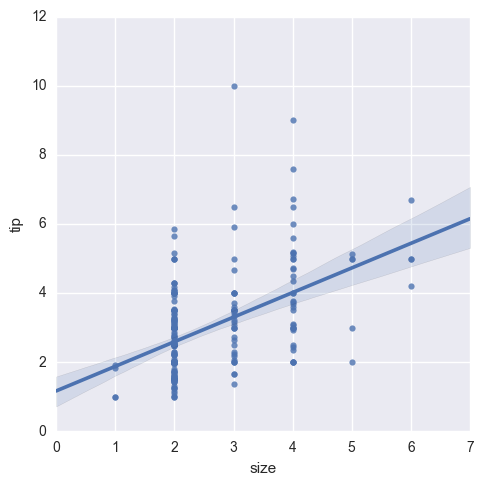

In [8]:
sns.lmplot(x="size", y="tip", data=tips)

One option is to add some random noise ("jitter") to the discrete values to make the distribution of those values more clear. Note that jitter is applied only to the scatterplot data and does not influence the regression line fit itself:

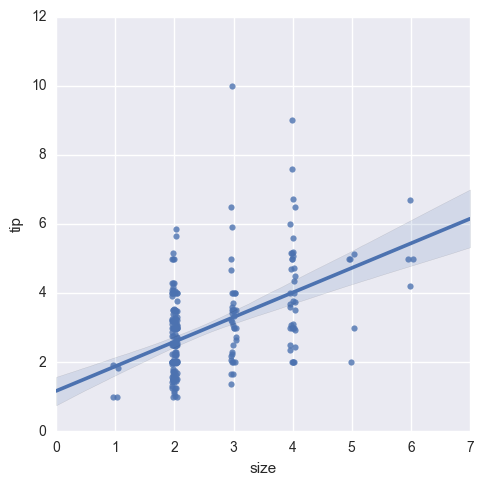

In [9]:
sns.lmplot(x="size", y="tip", data=tips, x_jitter=.05)

A second option is to collapse over the observations in each discrete bin to plot an estimate of central tendency along with a confidence interval:

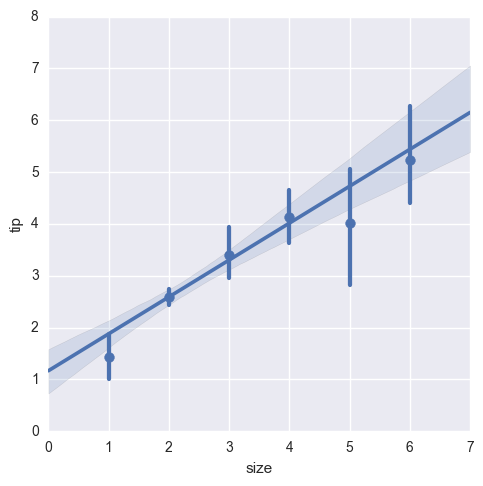

In [10]:
sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean)

Fitting different kinds of models
---------------------------------

The simple linear regression model used above is very simple to fit, however, it is not appropriate for some kinds of datasets. The `Anscombe's quartet <https://en.wikipedia.org/wiki/Anscombe%27s_quartet>`_ dataset shows a few examples where simple linear regression provides an identical estimate of a relationship where simple visual inspection clearly shows differences. For example, in the first case, the linear regression is a good model:

In [11]:
anscombe = sns.load_dataset("anscombe")

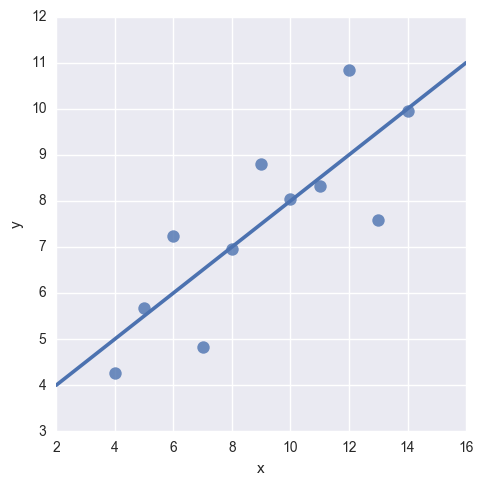

In [12]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'I'"),
           ci=None, scatter_kws={"s": 80})

The linear relationship in the second dataset is the same, but the plot clearly shows that this is not a good model:

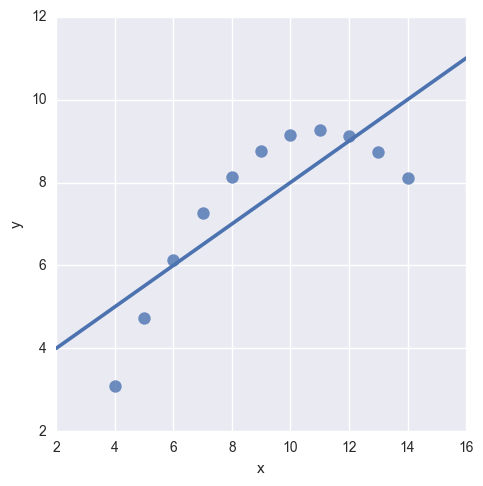

In [13]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
           ci=None, scatter_kws={"s": 80})

In the presence of these kind of higher-order relationships, `lmplot` and `regplot` can fit a polynomial regression model to explore simple kinds of nonlinear trends in the dataset:

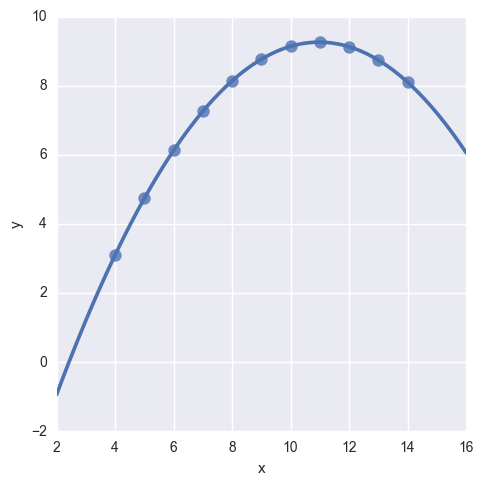

In [14]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
           order=2, ci=None, scatter_kws={"s": 80})

A different problem is posed by "outlier" observations that deviate for some reason other than the main relationship under study:

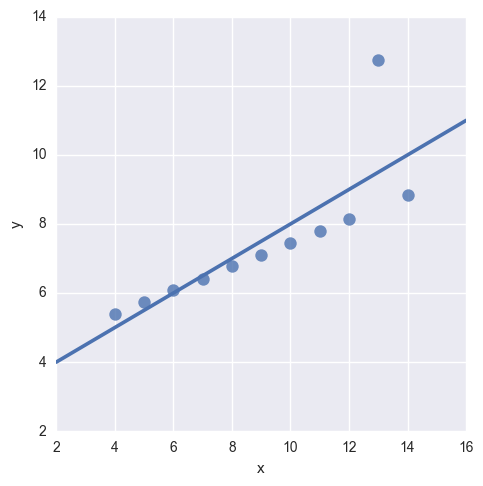

In [15]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"),
           ci=None, scatter_kws={"s": 80})

In the presence of outliers, it can be useful to fit a robust regression, which uses a different loss function to downweight relatively large residuals:

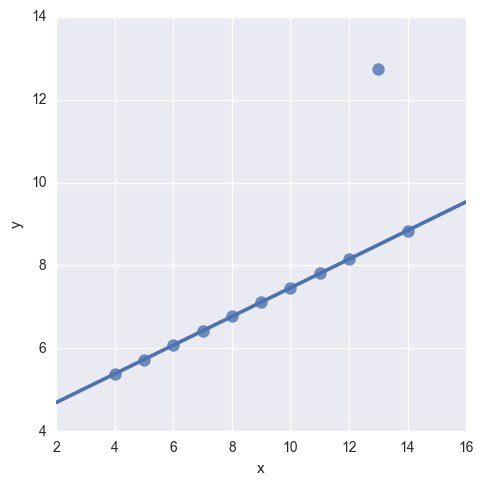

In [16]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"),
           robust=True, ci=None, scatter_kws={"s": 80})

When the ``y`` variable is binary, simple linear regression also "works" but provides implausible predictions:

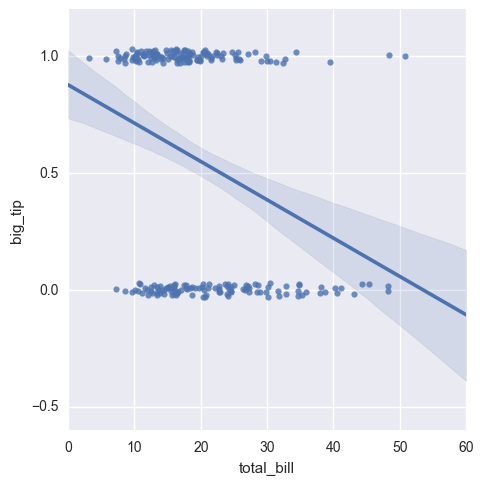

In [17]:
tips["big_tip"] = (tips.tip / tips.total_bill) > .15
sns.lmplot(x="total_bill", y="big_tip", data=tips,
           y_jitter=.03)

The solution in this case is to fit a logistic regression, such that the regression line shows the estimated probability of ``y = 1`` for a given value of ``x``:

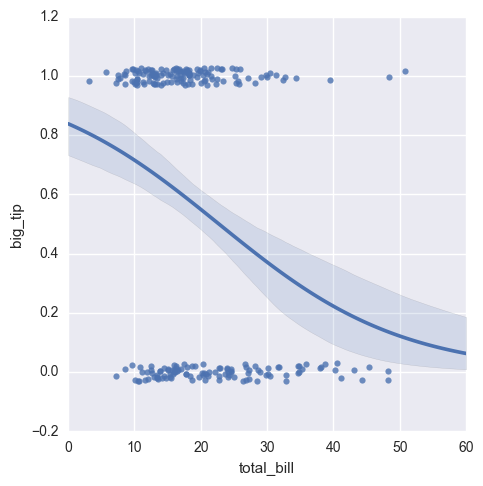

In [18]:
sns.lmplot(x="total_bill", y="big_tip", data=tips,
           logistic=True, y_jitter=.03)

Note that the logistic regression estimate is considerably more computationally intensive (this is true of robust regression as well) than simple regression, and as the confidence interval around the regression line is computed using a bootstrap procedure, you may wish to turn this off for faster iteration (using ``ci=False``).

An altogether different approach is to fit a nonparametric regression using a `lowess smoother <https://en.wikipedia.org/wiki/Local_regression>`_. This approach has the fewest assumptions, although it is computationally intensive and so currently confidence intervals are not computed at all:

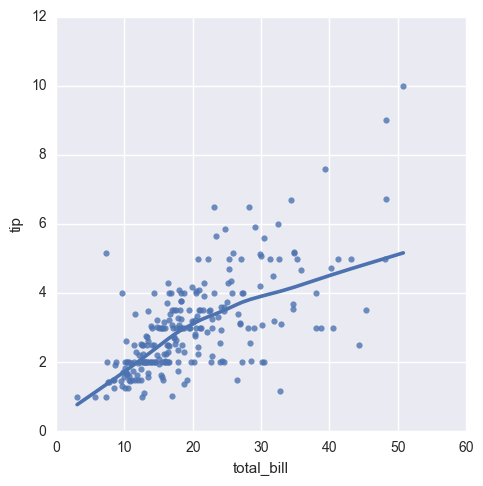

In [19]:
sns.lmplot(x="total_bill", y="tip", data=tips,
           lowess=True)

The `residplot` function can be a useful tool for checking whether the simple regression model is appropriate for a dataset. It fits and removes a simple linear regression and then plots the residual values for each observation. Ideally, these values should be randomly scattered around ``y = 0``:

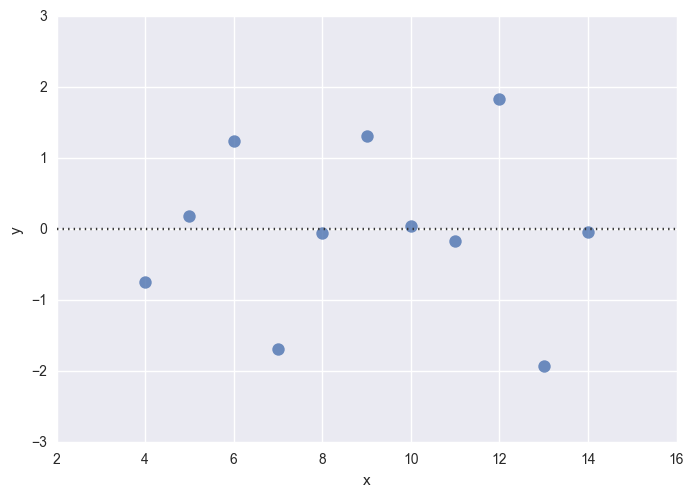

In [20]:
sns.residplot(x="x", y="y", data=anscombe.query("dataset == 'I'"),
              scatter_kws={"s": 80})

If there is structure in the residuals, it suggests that simple linear regression is not appropriate:

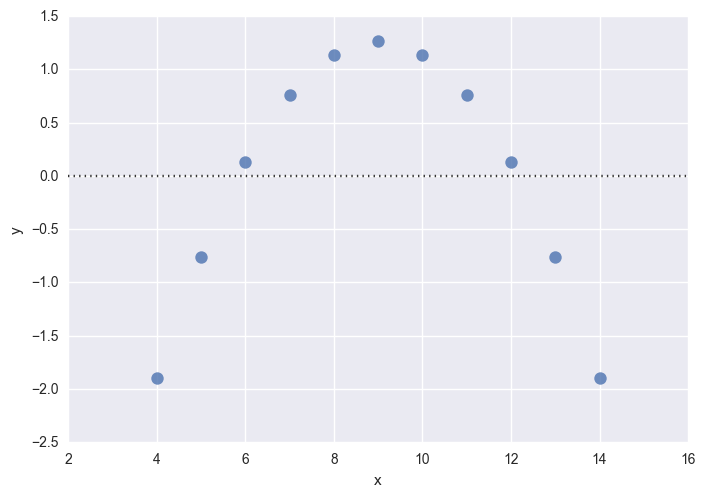

In [21]:
sns.residplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
              scatter_kws={"s": 80})

Conditioning on other variables
-------------------------------

The plots above show many ways to explore the relationship between a pair of variables. Often, however, a more interesting question is "how does the relationship between these two variables change as a function of a third variable?" This is where the difference  between `regplot` and `lmplot` appears. While `regplot` always shows a single relationsihp, `lmplot` combines `regplot` with `FacetGrid` to provide an easy interface to show a linear regression on "faceted" plots that allow you to explore interactions with up to three additional categorical variables.

The best way to separate out a relationship is to plot both levels on the same axes and to use color to distinguish them:

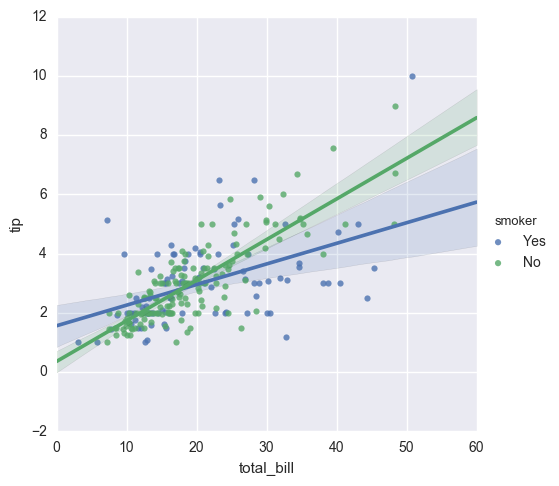

In [22]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips)

In addition to color, it's possible to use different scatterplot markers to make plots the reproduce to black and white better. You also have full control over the colors used:

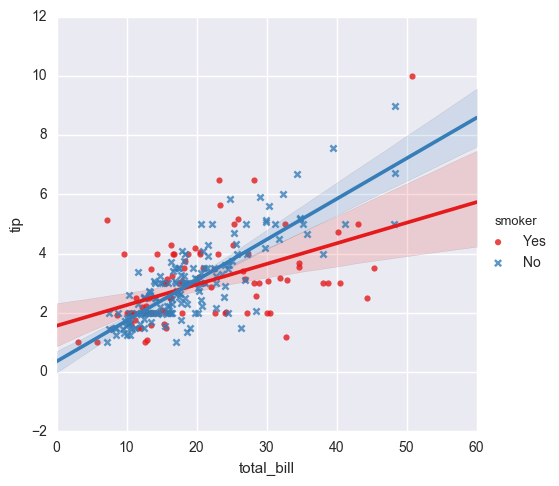

In [23]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips,
           markers=["o", "x"], palette="Set1")

To add another variable, you can draw multiple "facets" which each level of the variable appearing in the rows or columns of the grid:

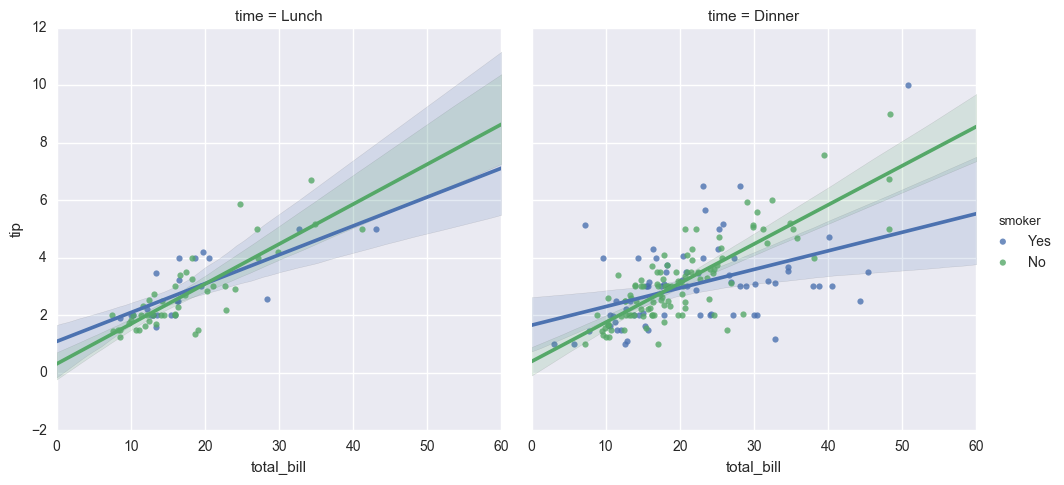

In [24]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", data=tips)

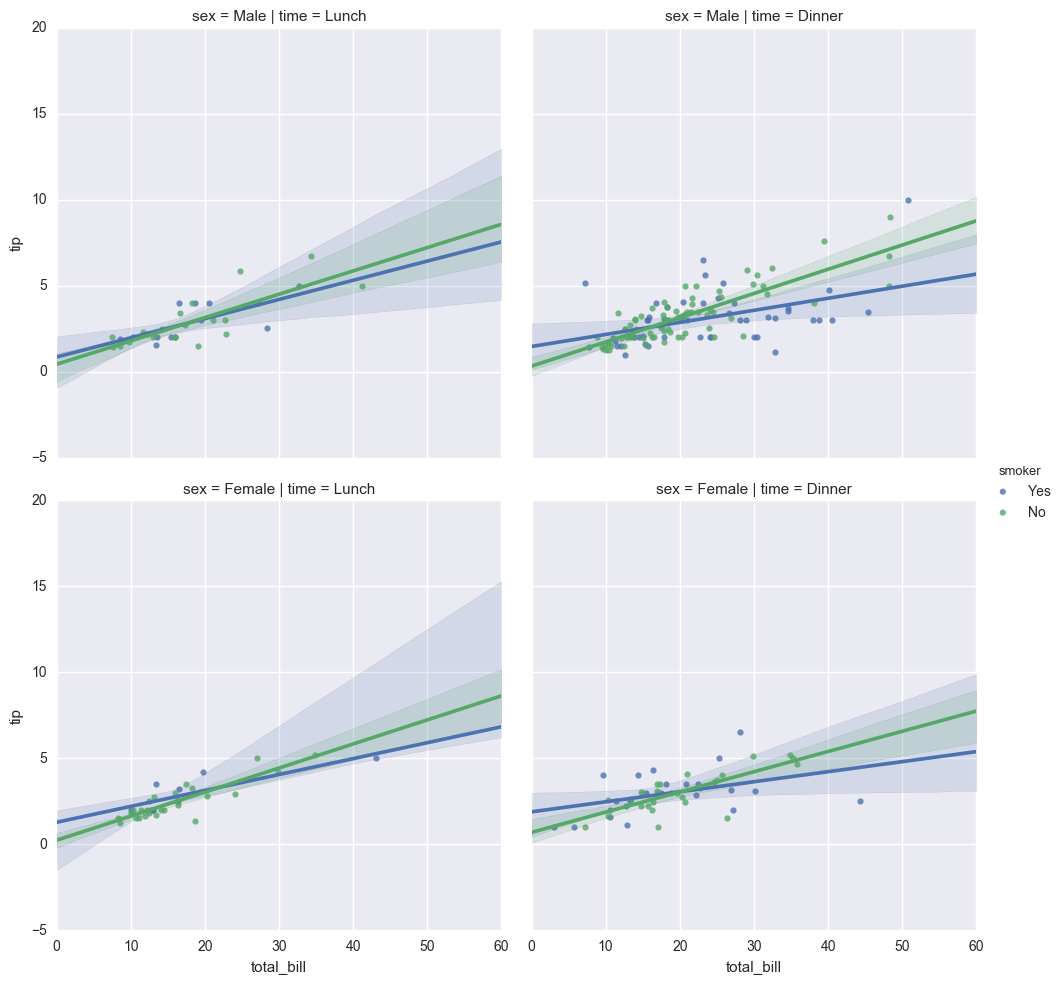

In [25]:
sns.lmplot(x="total_bill", y="tip", hue="smoker",
           col="time", row="sex", data=tips)

Controlling the size and shape of the plot
------------------------------------------

Before we noted that the default plots made by `regplot` and `lmplot` look the same but on axes that have a different size and shape. This is because func:`regplot` is an "axes-level" function draws onto a specific axes. This means that you can make mutli-panel figures yourself and control exactly where the the regression plot goes. If no axes is provided, it simply uses the "currently active" axes, which is why the default plot has the same size and shape as most other matplotlib functions. To control the size, you need to create a figure object yourself.

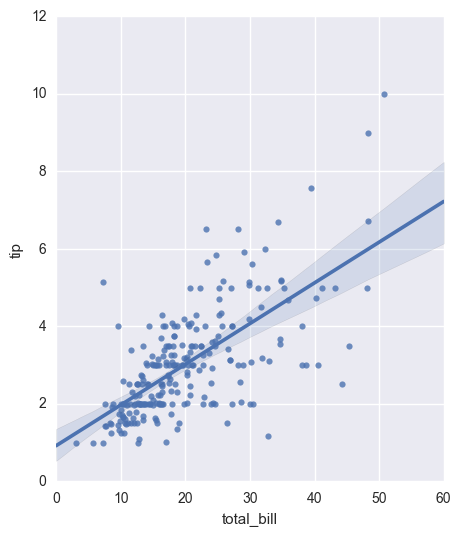

In [26]:
f, ax = plt.subplots(figsize=(5, 6))
sns.regplot(x="total_bill", y="tip", data=tips, ax=ax)

In contrast, the size and shape of the `lmplot` figure is controlled through the `FacetGrid` interface using the ``size`` and ``aspect`` parameters, which apply to each *facet* in the plot, not to the overall figure itself:

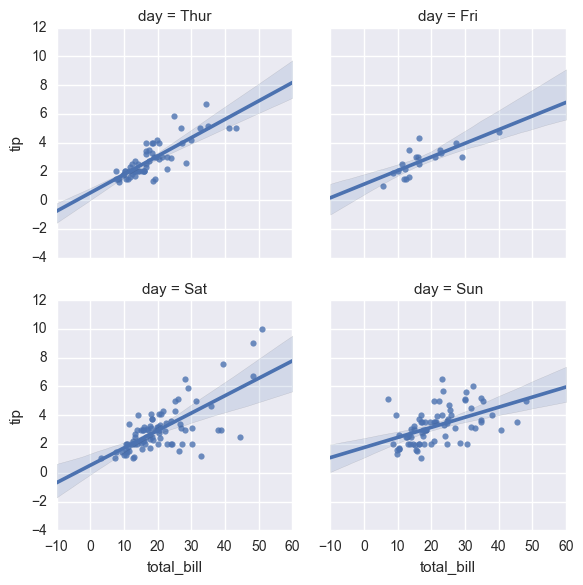

In [27]:
sns.lmplot(x="total_bill", y="tip", col="day", data=tips,
           col_wrap=2, size=3)

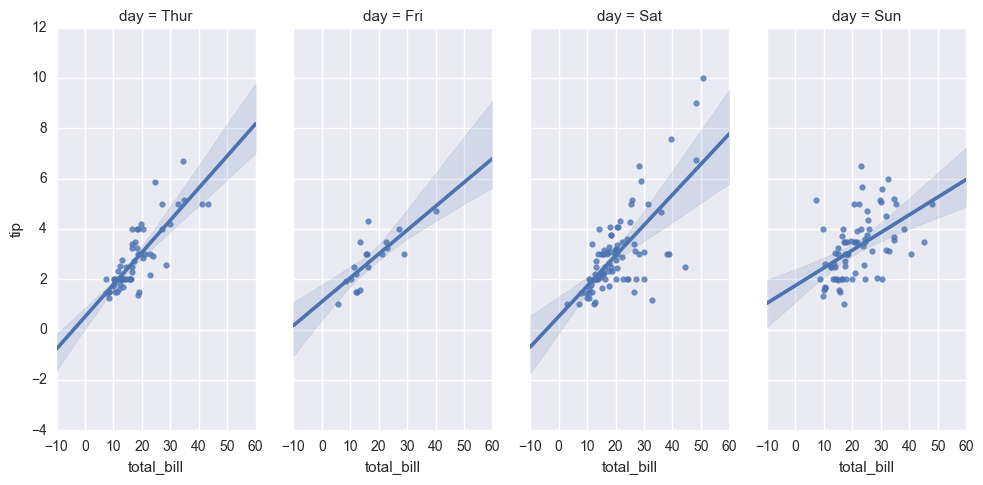

In [28]:
sns.lmplot(x="total_bill", y="tip", col="day", data=tips,
           aspect=.5)

Plotting a regression in other contexts
---------------------------------------

A few other seaborn functions use `regplot` in the context of a larger, more complex plot. The first is the `jointplot` function that we introduced in the :ref:`distributions tutorial <distribution_tutorial>`. In addition to the plot styles previously discussed, `jointplot` can use `regplot` to show the linear regression fit on the joint axes by passing ``kind="reg"``:

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


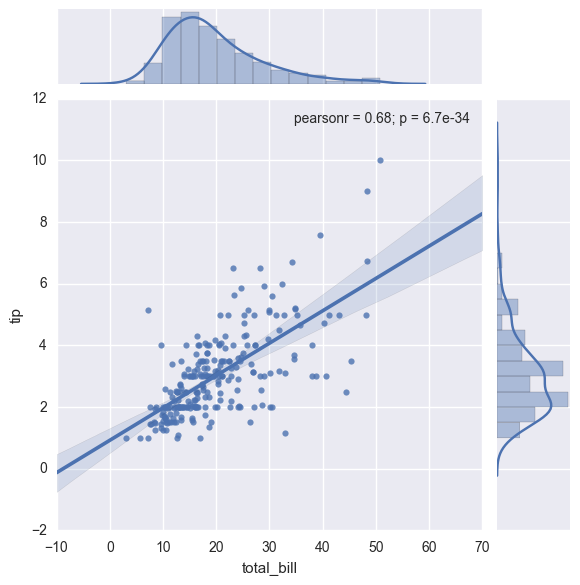

In [29]:
sns.jointplot(x="total_bill", y="tip", data=tips, kind="reg")

Using the `pairplot` function with ``kind="reg"`` combines `regplot` and `PairGrid` to show the linear relationship between variables in a dataset. Take care to note how this is different from `lmplot`. In the figure below, the two axes don't show the same relationship conditioned on two levels of a third variable; rather, `PairGrid` is used to show multiple relationships between different pairings of the variables in a dataset:

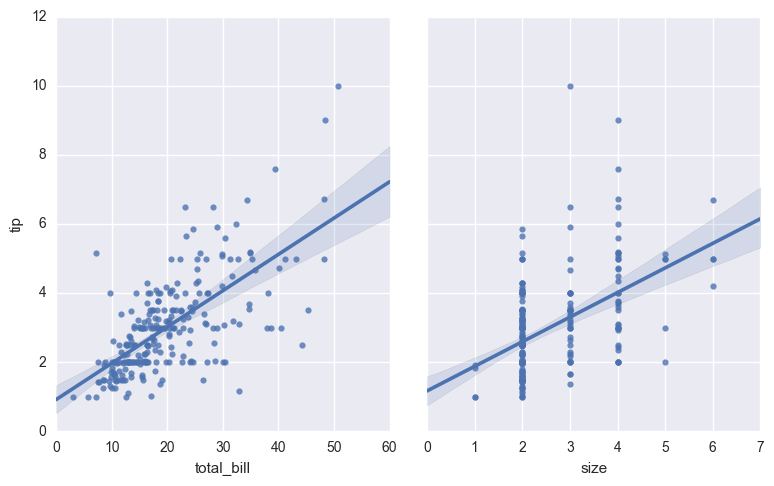

In [30]:
sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
             size=5, aspect=.8, kind="reg")

Like `lmplot`, but unlike `jointplot`, conditioning on an additional categorical variable is built into `pairplot` using the ``hue`` parameter:

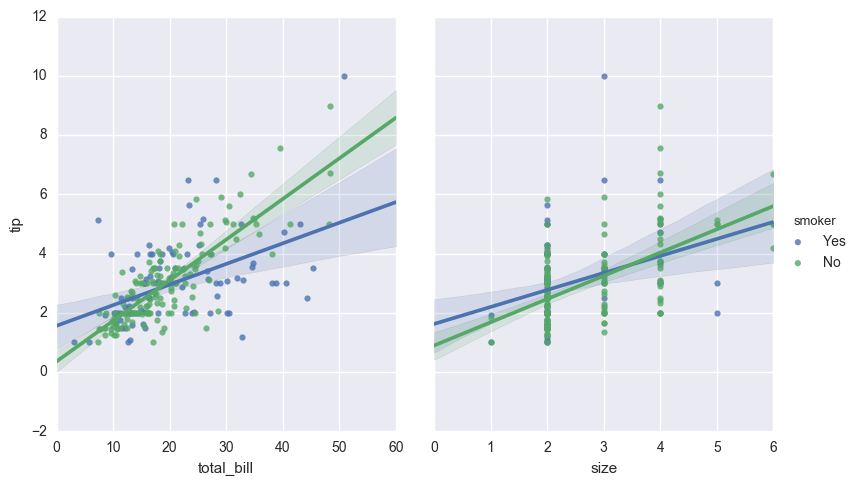

In [31]:
sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
             hue="smoker", size=5, aspect=.8, kind="reg")